# Morning: Introduction to Time Series Analysis
The simplest demonstration of temporal dependence is seen by considering a univariate time series $y(t)$. In our case, $y(t)$ may be the surface-level atmsopheric concentration of ozone at a single EPA air-quality station in Orange County.

In [1]:
#-- Import Required Python Packages
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

#-- Import R packages in Python
r = robjects.r
nlme = importr('nlme')
stats = importr('stats')

## What generates the pattern?

## Is there a trend?

In [2]:
#-- Get El Nino data
sst = np.loadtxt('../Data/detrend.nino34.ascii.txt',skiprows=1)
y1 = sst[:,2]
t1 = np.linspace(1950,2017,len(y1))

#-- Convert Numpy arrays to R objects
robjects.globalenv["y1"] = robjects.FloatVector(y1)
robjects.globalenv["t1"] = robjects.FloatVector(t1)

#-- fit and display results
print r.summary(r.lm("y1 ~ t1"))


Call:
(function (formula, data, subset, weights, na.action, method = "qr", 
    model = TRUE, x = FALSE, y = FALSE, qr = TRUE, singular.ok = TRUE, 
    contrasts = NULL, offset, ...) 
{
    ret.x <- x
    ret.y <- y
    cl <- match.call()
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (method == "model.frame") 
        return(mf)
    else if (method != "qr") 
        warning(gettextf("method = '%s' is not supported. Using 'qr'", 
            method), domain = NA)
    mt <- attr(mf, "terms")
    y <- model.response(mf, "numeric")
    w <- as.vector(model.weights(mf))
    if (!is.null(w) && !is.numeric(w)) 
        stop("'weights' must be a numeric vector")
    offset <- as.vector(model.offset(mf))
    if (!is.null(offset)) {
        if (length(offse

## Generate sample realizations

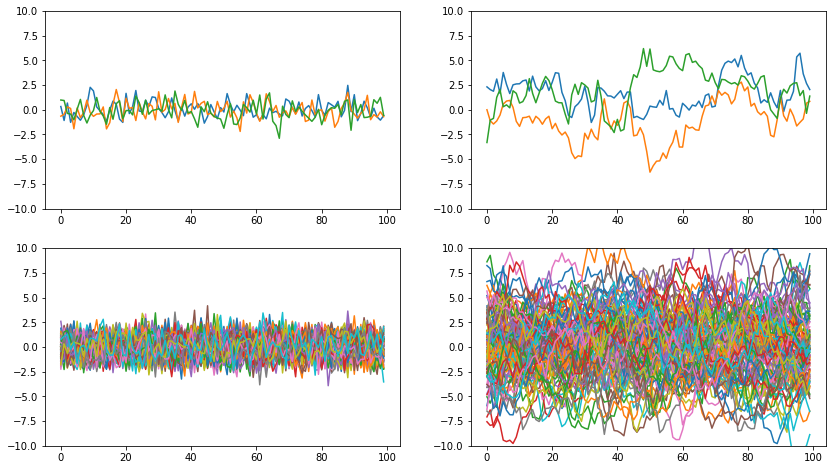

In [3]:
#-- Set up figure
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

#-- 3 sample curves
for i in range(3):
    ax1.plot(np.array(r.rnorm(100)))
    ax2.plot(np.array(stats.arima_sim(100,model=robjects.ListVector({'ar':0.95}))))
    ax1.set_ylim([-10,10])
    ax2.set_ylim([-10,10])
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

#-- 100 sample curves
for i in range(100):
    ax3.plot(np.array(r.rnorm(100)))
    ax4.plot(np.array(stats.arima_sim(100,model=robjects.ListVector({'ar':0.95}))))
    ax3.set_ylim([-10,10])
    ax4.set_ylim([-10,10])

plt.show()

## The autocorrelation function

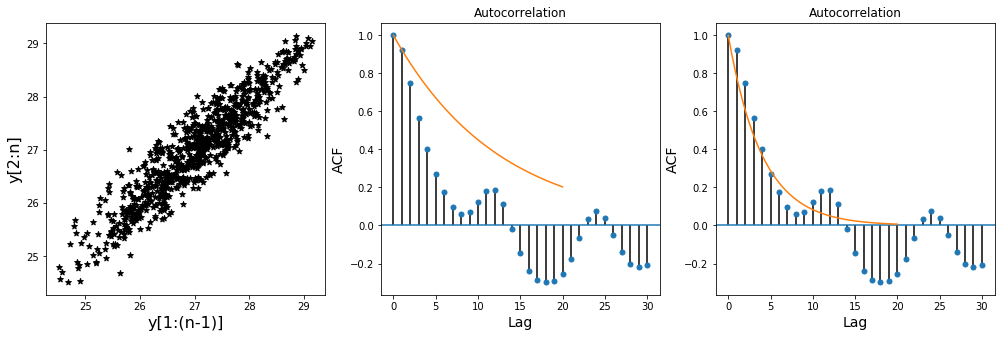

In [4]:
#-- Use the same sst data as above
#-- Set up figure
fig = plt.figure(figsize=(17,5))
ax1 = fig.add_subplot(131)

#-- Plot scatter plot of values shifted by 1
ax1.scatter(y1[:-1],y1[1:],color='k',marker='*')
ax1.set_xlabel('y[1:(n-1)]',fontsize=16)
ax1.set_ylabel('y[2:n]',fontsize=16)

#-- plot autocorrelation
ax2 = fig.add_subplot(132)
sm.graphics.tsa.plot_acf(y1,lags=30,alpha=None,ax=ax2)
alpha_hat1 = np.corrcoef(y1[:-1],y1[1:])[0,1]
ax2.plot(np.linspace(0,20),alpha_hat1**np.linspace(0,20))
ax2.set_xlabel('Lag', fontsize=14)
ax2.set_ylabel('ACF',fontsize=14)

ax3 = fig.add_subplot(133)
sm.graphics.tsa.plot_acf(y1,lags=30,alpha=None,ax=ax3)
ax3.plot(np.linspace(0,20),0.78**np.linspace(0,20))
ax3.set_xlabel('Lag', fontsize=14)
ax3.set_ylabel('ACF',fontsize=14)
plt.show()

## Generate various time series structures

## Simulation of slope estimation

## Simple trend analysis with autocorrelation

In [5]:
print r.summary(nlme.gls(r.formula("y1 ~ t1"), correlation=nlme.corAR1()))

Generalized least squares fit by REML
  Model: y1 ~ t1 
  Data: NULL 
       AIC      BIC    logLik
  637.1089 655.8723 -314.5545

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.9272067 

Coefficients:
               Value Std.Error   t-value p-value
(Intercept) 5.816964 16.795079 0.3463493  0.7292
t1          0.010672  0.008467 1.2603950  0.2079

 Correlation: 
   (Intr)
t1 -1    

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.4783251 -0.6540165  0.1030884  0.6908156  2.0707585 

Residual standard error: 0.9484359 
Degrees of freedom: 807 total; 805 residual



# MORNING BREAK

# Analysis of Orange Country ozone time series

# Simple trend analysis

In [6]:
#- Read Ozone data from CSV file
d = pd.read_csv('../Data/ozone_orange.csv')
#- Get ozone data except for 2016 
ind = np.nonzero(d['year']!=2016)
y2 = np.array(d['ozone'])[ind]
years = np.array(d['year'])[ind]
t2 = np.linspace(years.min(),years.max(),len(y2))

In [7]:
robjects.globalenv["y2"] = robjects.FloatVector(y2)
robjects.globalenv["t2"] = robjects.FloatVector(t2)
print r.summary(nlme.gls(r.formula("y2 ~ t2"), correlation=nlme.corAR1(),method='ML'))

Generalized least squares fit by maximum likelihood
  Model: y2 ~ t2 
  Data: NULL 
        AIC       BIC   logLik
  -21910.74 -21886.67 10959.37

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.8552849 

Coefficients:
                  Value Std.Error     t-value p-value
(Intercept)  0.03422281 0.6293315  0.05437963  0.9566
t2          -0.00000413 0.0003138 -0.01316690  0.9895

 Correlation: 
   (Intr)
t2 -1    

Standardized residuals:
         Min           Q1          Med           Q3          Max 
-2.056608887 -0.800994961  0.009574762  0.706174031  3.184672958 

Residual standard error: 0.01261744 
Degrees of freedom: 3035 total; 3033 residual



# Harmonic regression

In [8]:
#-- Get year interval
nyrs= years.max() - years.min()
f = np.linspace(0,2*np.pi*nyrs,len(y2))
sinf = np.sin(f)
cosf = np.cos(f)

In [9]:
robjects.globalenv["sinf"] = robjects.FloatVector(sinf)
robjects.globalenv["cosf"] = robjects.FloatVector(cosf)
print r.summary(nlme.gls(r.formula("y2 ~ sinf + cosf"), correlation=nlme.corAR1(),method='ML'))

Generalized least squares fit by maximum likelihood
  Model: y2 ~ sinf + cosf 
  Data: NULL 
        AIC       BIC   logLik
  -22053.52 -22023.43 11031.76

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7700548 

Coefficients:
                  Value    Std.Error  t-value p-value
(Intercept) 0.025893952 0.0005036630 51.41126  0.0000
sinf        0.000891778 0.0007113883  1.25357  0.2101
cosf        0.010826465 0.0007096038 15.25706  0.0000

 Correlation: 
     (Intr) sinf  
sinf  0.000       
cosf -0.004  0.000

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.97903286 -0.72563451 -0.03934443  0.67355001  3.73500124 

Residual standard error: 0.0100069 
Degrees of freedom: 3035 total; 3032 residual



# Aliasing

# Time series decomposition

In [10]:
fit = nlme.gls(r.formula("y2 ~ sinf + cosf + t2"), correlation=nlme.corAR1(),method='ML')

In [11]:
k_hat = fit.rx2('coefficients')
print k_hat
k_hat_var = np.array(fit.rx2('varBeta'))
print k_hat_var
phi_hat = stats.coef(fit.rx2("modelStruct"),unconstrained=False)
e = np.array(fit.rx2('residuals'))

  (Intercept)          sinf          cosf            t2 
-8.728852e-03  8.972455e-04  1.082647e-02  1.726393e-05 

[[  1.51555016e-01  -2.39327705e-05  -1.27465230e-09  -7.55695647e-05]
 [ -2.39327705e-05   5.09997235e-07  -1.55858674e-19   1.19335679e-08]
 [ -1.27465230e-09  -1.55858674e-19   5.03681416e-07  -4.92254945e-19]
 [ -7.55695647e-05   1.19335679e-08  -4.92254945e-19   3.76811591e-08]]


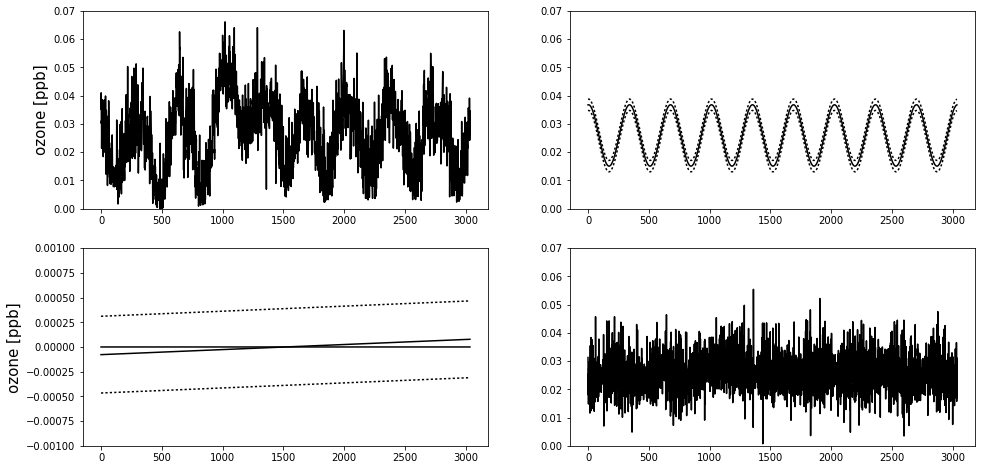

In [12]:
#-- Plot results
#-- Set up figure
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(221)
ax1.plot(y2,'k-')
ax1.set_ylim([0,0.07])
ax1.set_ylabel('ozone [ppb]',fontsize=15)

ax2 = fig.add_subplot(222)
f_hat = np.mean(y2) + k_hat[1]*sinf + k_hat[2]*cosf
ax2.plot(f_hat,'k-')
ax2.plot(f_hat + 2*np.sqrt(k_hat_var[1,1] + k_hat_var[2,2]),'k:') #-- note the variance is already std^2
ax2.plot(f_hat - 2*np.sqrt(k_hat_var[1,1] + k_hat_var[2,2]),'k:')
ax2.set_ylim([0,0.07])

ax3 = fig.add_subplot(223)
t_hat = k_hat[0] + k_hat[3]*t2
t_hat -= np.mean(t_hat)
ax3.plot(t_hat,'k-')
ax3.plot(t_hat + 2*np.sqrt(k_hat_var[3,3]),'k:')
ax3.plot(t_hat - 2*np.sqrt(k_hat_var[3,3]),'k:')
ax3.plot(np.zeros(len(t_hat)),'k-')
ax3.set_ylabel('ozone [ppb]',fontsize=15)
ax3.set_ylim([-0.001,0.001])

ax4 = fig.add_subplot(224)
ear = e[1:]-phi_hat*e[:-1]
ax4.plot(np.mean(y2)+ear,'k-')
ax4.set_ylim([0,0.07])

plt.show()

# Time series regression